# Методы исследования характеристических свойств нейронных сетей с применением теоретико-игрового подхода

- **Теория**: И.В.Томилов ivan-tomilov3@yandex.ru
- **Реализация**: М.А.Зайцева maria@tail-call.ru

После того, как модель починилась, нужно повторить на нескольких разных
датасетах.

## Задачи

- *DONE* Повторять на двух датасетах
- *DONE* Избавиться от dabs_mean_std
- *DONE* На каждом графике отображать его датасет
- *DONE* Повторять на трёх датасетах
- `TODO` Сохранить $\mathrm{loss}(\mathrm{epoch})$ в виде графика и JSON
- `TODO` Сохранить $\mathrm{metric}(\mathrm{noise})$ в виде графика и JSON
- `TODO` $P$ in $[0, 0.01, 0.05, 0.5, 0.9, 0.99]$
- `TODO` Каждый эксперимент повторяется 10 раз
- `TODO` Accuracy/F1 Score и ROC AUC на разных графиках
- `TODO` Результат получен, всё упаковано и подписано

## Настройки

In [89]:
TEST_SAMPLE_SIZE = 0.2
RANDOM_STATE = 23432
BATCH_SIZE = 12
EPOCHS = 10
LEARNING_RATE = 0.00011
P = 0.05

NOISE_SAMPLES_COUNT = 50
NOISE_FACTORS = [
    x * 2/NOISE_SAMPLES_COUNT for x in range(NOISE_SAMPLES_COUNT)
]

In [90]:
pip install torch torchvision pandas scikit-learn 'numpy<2'


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Данные

In [91]:
import torch
import torch.nn as nn
from dataclasses import dataclass

@dataclass
class LearningTask:
    criterion: object
    dtype: torch.dtype

classification_task = LearningTask(
    criterion=nn.CrossEntropyLoss(),
    dtype=torch.long
)

regression_task = LearningTask(
    criterion=nn.MSELoss(),
    dtype=torch.float
)

In [92]:
import time
from typing import List, Tuple
from datetime import datetime

datetime_now = datetime.now()
time_now = time.time()

import urllib.request
import pandas as pd
import os

from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import TensorDataset

import sys
with open('log.txt', 'a') as file:
    file.write(f'{datetime.now().isoformat()} A {sys.argv[0]} is {time.time() - time_now}\n')

def download_csv(
    url: str,
    saved_name: str,
    features: List[str] = None
) -> pd.DataFrame:
    data_dir = 'data'
    os.makedirs(data_dir, exist_ok=True)
    file_path = os.path.join(data_dir, saved_name)

    urllib.request.urlretrieve(url, file_path)

    if features is None:
        return pd.read_csv(file_path)
    else:
        return pd.read_csv(file_path, header=None, names=features)

def dataset_from_dataframe(
    df: pd.DataFrame,
    target: str,
    y_dtype: type
) -> TensorDataset:
    X = df.drop(columns=[target]).values
    y = df[target].values

    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=y_dtype)

    return TensorDataset(X_tensor, y_tensor)

In [93]:
def breast_cancer_dataset() -> Tuple[TensorDataset, TensorDataset]:
    df = download_csv(
        url='https://raw.githubusercontent.com/dataspelunking/MLwR/refs/heads/master/Machine%20Learning%20with%20R%20(2nd%20Ed.)/Chapter%2003/wisc_bc_data.csv',
        saved_name='wisc_bc_data.csv'
    )

    target = 'diagnosis'

    df[target] = df[target].map({ 'M': 0, 'B': 1 })
    df = df.drop(columns=['id'])

    train_df, val_df = train_test_split(
        df,
        test_size=TEST_SAMPLE_SIZE,
        random_state=RANDOM_STATE
    )

    return (
        dataset_from_dataframe(
            df=train_df,
            target=target,
            y_dtype=classification_task.dtype
        ),
        dataset_from_dataframe(
            df=val_df,
            target=target,
            y_dtype=classification_task.dtype
        )
    )

In [94]:
def car_evaluation_dataset() -> Tuple[TensorDataset, TensorDataset]:
    df = download_csv(
        url='https://raw.githubusercontent.com/mragpavank/car-evaluation-dataset/refs/heads/master/car_evaluation.csv',
        saved_name='car_evaluation.csv',
        features=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']
    )

    target = 'class'

    df[target] = df[target].map({
        'unacc': 0,
        'acc': 1,
        'good': 2,
        'vgood': 3,
    })

    df['doors'] = df['doors'].map({
        '2': 2,
        '3': 3,
        '4': 4,
        '5more': 5
    })

    high_map = {
        'low': 0,
        'med': 1,
        'high': 2,
        'vhigh': 3
    }

    df['buying'] = df['buying'].map(high_map)
    df['safety'] = df['safety'].map(high_map)
    df['maint'] = df['maint'].map(high_map)

    df['persons'] = df['persons'].map({
        '2': 2,
        '4': 4,
        'more': 6
    })

    df['lug_boot'] = df['lug_boot'].map({
        'small': 0,
        'med': 1,
        'big': 2
    })

    train_df, val_df = train_test_split(
        df,
        test_size=TEST_SAMPLE_SIZE,
        random_state=RANDOM_STATE
    )
    return (
        dataset_from_dataframe(
            df=train_df,
            target=target,
            y_dtype=classification_task.dtype
        ),
        dataset_from_dataframe(
            df=val_df,
            target=target,
            y_dtype=classification_task.dtype
        )
    )

In [95]:

def student_performance_factors_dataset() -> Tuple[TensorDataset, TensorDataset]:
    df = pd.read_csv('data/StudentPerformanceFactors.csv')

    target = 'Exam_Score'

    lmh = {
        'Low': -1,
        'Medium': 0,
        'High': +1,
    }

    yn = {
        'Yes': +1,
        'No': -1,
    }

    df = df.dropna(subset=['Teacher_Quality'])

    df['Parental_Involvement'] = df['Parental_Involvement'].map(lmh)
    df['Access_to_Resources'] = df['Access_to_Resources'].map(lmh)
    df['Extracurricular_Activities'] = df['Extracurricular_Activities'].map(yn)
    df['Motivation_Level'] = df['Motivation_Level'].map(lmh)
    df['Internet_Access'] = df['Internet_Access'].map(yn)
    df['Family_Income'] = df['Family_Income'].map(lmh)
    df['Teacher_Quality'] = df['Teacher_Quality'].map(lmh)
    df['School_Type'] = df['School_Type'].map({
        'Public': +1,
        'Private': -1,
    })
    df['Peer_Influence'] = df['Peer_Influence'].map({
        'Positive': +1,
        'Neutral': 0,
        'Negative': -1,
    })
    df['Learning_Disabilities'] = df['Learning_Disabilities'].map(yn)
    df['Parental_Education_Level'] = df['Parental_Education_Level'].map({
        'Postgraduate': +3,
        'College': +2,
        'High School': +1,
    }).fillna(0)
    df['Distance_from_Home'] = df['Distance_from_Home'].map({
        'Near': +1,
        'Moderate': 0,
        'Far': -1,
    }).fillna(0)
    df['Gender'] = df['Gender'].map({
        'Female': +1,
        'Male': -1,
    }).fillna(0)

    train_df, val_df = train_test_split(
        df,
        test_size=TEST_SAMPLE_SIZE,
        random_state=RANDOM_STATE
    )

    return (
        dataset_from_dataframe(
            df=train_df,
            target=target,
            y_dtype=regression_task.dtype
        ),
        dataset_from_dataframe(
            df=val_df,
            target=target,
            y_dtype=regression_task.dtype
        )
    )

In [96]:
from dataclasses import dataclass

import pandas as pd
from torch.utils.data import DataLoader

@dataclass
class DatasetData:
    train_dataset: pd.DataFrame
    test_dataset: pd.DataFrame
    train_loader: DataLoader
    test_loader: DataLoader

@dataclass
class Dataset:
    name: str
    features_count: int
    classes_count: int
    data: DatasetData

In [97]:

from torch.utils.data import DataLoader

def make_dataset1(batch_size: int) -> Dataset:
    train_dataset, test_dataset = breast_cancer_dataset()

    return Dataset(
        name='wisc_bc_data.csv',
        features_count=train_dataset[1][0].shape[0],
        classes_count=2,
        data=DatasetData(
            train_dataset=train_dataset,
            test_dataset=test_dataset,
            train_loader=DataLoader(
                train_dataset,
                batch_size=batch_size,
                shuffle=True
            ),
            test_loader=DataLoader(
                test_dataset,
                batch_size=batch_size,
                shuffle=False
            )
        )
    )

def make_dataset2(batch_size: int) -> Dataset:
    train_dataset, test_dataset = car_evaluation_dataset()

    return Dataset(
        name='car_evaluation.csv',
        features_count=train_dataset[1][0].shape[0],
        classes_count=4,
        data=DatasetData(
            train_dataset=train_dataset,
            test_dataset=test_dataset,
            train_loader=DataLoader(
                train_dataset,
                batch_size=batch_size,
                shuffle=True
            ),
            test_loader=DataLoader(
                test_dataset,
                batch_size=batch_size,
                shuffle=False
            )
        )
    )

def make_dataset3(batch_size: int) -> Dataset:
    train_dataset, test_dataset = student_performance_factors_dataset()

    return Dataset(
        name='StudentPerformanceFactors.csv',
        features_count=train_dataset[1][0].shape[0],
        classes_count=1,
        data=DatasetData(
            train_dataset=train_dataset,
            test_dataset=test_dataset,
            train_loader=DataLoader(
                train_dataset,
                batch_size=batch_size,
                shuffle=True
            ),
            test_loader=DataLoader(
                test_dataset,
                batch_size=batch_size,
                shuffle=False
            )
        )
    )

datasets = [
    make_dataset1(batch_size=12),
    make_dataset2(batch_size=12),
    make_dataset3(batch_size=12),
]


## Модели

In [98]:
import torch

class CustomBackwardFunction(torch.autograd.Function):
    """
    Переопределённая функция для линейного слоя.
    """
    @staticmethod
    def forward(
        ctx,
        p: float,
        input: torch.Tensor,
        weight: torch.Tensor,
        bias: float = None
    ):
        ctx.save_for_backward(torch.scalar_tensor(p), input, weight, bias)

        output = input.mm(weight.t())
        if bias is not None:
            output += bias

        return output

    @staticmethod
    def backward(ctx, grad_output: torch.Tensor):
        p, input, weight, bias = ctx.saved_tensors

        height = weight.size(0)
        bernoulli_mask = torch.bernoulli(torch.ones(height) * (1 - p.item()))
 
        diagonal_mask = torch.diag(bernoulli_mask) / (1 - p.item())

        grad_output = grad_output.mm(diagonal_mask)

        grad_input = grad_output.mm(weight)
        grad_weight = grad_output.t().mm(input)

        if bias is not None:
            grad_bias = grad_output.sum(0)
        else:
            grad_bias = None

        return None, grad_input, grad_weight, grad_bias

class CustomReLUBackwardFunction(torch.autograd.Function):
    """
    Переопределённая функция для слоя ReLU.
    """
    @staticmethod
    def forward(ctx, p: float, input: torch.Tensor):
        ctx.save_for_backward(torch.scalar_tensor(p), input)
        return F.relu(input)

    @staticmethod
    def backward(ctx, grad_output: torch.Tensor):
        p, input = ctx.saved_tensors

        grad_output = grad_output * (input > 0).float()

        # У матриц ось 0 это Y
        height = grad_output.size(0)
        bernoulli_mask = torch.bernoulli(torch.ones(height) * (1 - p.item()))
        diagonal_mask = torch.diag(bernoulli_mask) / (1 - p.item())

        diagonal_mask = diagonal_mask.unsqueeze(1).expand(-1, grad_output.size(1), -1)
        diagonal_mask = diagonal_mask.permute(0, 2, 1)

        grad_output = grad_output.unsqueeze(1) * diagonal_mask
        grad_output = grad_output.sum(dim=1)

        return None, grad_output

    
class CustomReLUFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, p: float):
        ctx.save_for_backward(input, torch.scalar_tensor(p))
        return input.clamp(min=0)

    @staticmethod
    def backward(ctx, grad_output):
        input, p, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad_input[input <= 0] = 0

        # У матриц ось 0 это Y
        bernoulli_mask = torch.bernoulli(torch.ones(grad_input.size(0)) * (1 - p.item()))
        diagonal_mask = torch.diag(bernoulli_mask) / (1 - p.item()+1e-5)
        
        # Multiply grad_input with the diagonal matrix
        grad_input = diagonal_mask @ grad_input
        
        return grad_input, None
    
    
class CustomReLULayer(torch.nn.Module):
    def __init__(self, p: float):
        super(CustomReLULayer, self).__init__()
        self.p = p
        self.custom_relu_backward = CustomReLUFunction.apply

    def forward(self, x):
        return self.custom_relu_backward(x, self.p)

In [99]:


import torch.nn as nn
import torch.nn.functional as F

class RegularNetwork(nn.Module):
    """
    Нейросеть с обычными линейными слоями. Параметр `p` игнорируется.
    """
    def __init__(self, inputs_count: int, outputs_count: int, p: float):
        super(RegularNetwork, self).__init__()

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(inputs_count, 32 * 32)
        self.fc2 = nn.Linear(32 * 32, 32 * 32)
        self.fc3 = nn.Linear(32 * 32, outputs_count)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x


class AugmentedLinearNetwork(nn.Module):
    """
    Нейросеть с переопределённой функцией распространения ошибки
    для линейных слоёв.
    """
    def __init__(self, inputs_count: int, outputs_count: int, p: float):
        super(AugmentedReLUNetwork, self).__init__()

        self.flatten = nn.Flatten()
        self.p = p

        self.fc1 = nn.Linear(inputs_count, 32 * 32)
        self.fc2 = nn.Linear(32 * 32, 32 * 32)
        self.fc3 = nn.Linear(32 * 32, outputs_count)

        self.custom_backward = CustomBackwardFunction.apply

    def forward(self, x):
        x = self.flatten(x)
        x = self.custom_backward(self.p, x, self.fc1.weight, self.fc1.bias)
        x = F.relu(x)
        x = self.custom_backward(self.p, x, self.fc2.weight, self.fc2.bias)
        x = F.relu(x)
        x = self.fc3(x)
        return x

class AugmentedReLUNetwork(nn.Module):
    """
    Нейросеть с переопределённой функцией распространения ошибки
    для функции активации.
    """
    def __init__(self, inputs_count: int, outputs_count: int, p: float):
        super(AugmentedReLUNetwork, self).__init__()

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(inputs_count, 32 * 32)
        self.fc2 = nn.Linear(32 * 32, 32 * 32)
        self.fc3 = nn.Linear(32 * 32, outputs_count)

        self.custom_relu1 = CustomReLULayer(p)
        self.custom_relu2 = CustomReLULayer(p)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.custom_relu1(x)
        x = self.fc2(x)
        x = self.custom_relu2(x)
        x = self.fc3(x)
        return x



## Обучение

In [100]:
import torch

def dabs_mean_std(
    tensor1: torch.Tensor,
    tensor2: torch.Tensor
):
    dabs: torch.Tensor = torch.abs(tensor2 - tensor1)

    mean = torch.mean(dabs)
    std = torch.std(dabs)

    return (mean.item(), std.item())

In [101]:
import torch.optim as optim
import matplotlib.pyplot as plt

import torch.nn.init as init

def init_weights(m):
    if isinstance(m, nn.Linear):
        init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

def train(
    model: RegularNetwork, 
    dataset: Dataset,
    epochs: int,
    criterion,
    optimizer
):
    # Наблюдаемые величины
    running_losses: list[float] = []
    fc1_dabs_mean: list[float] = []
    fc1_dabs_std: list[float] = []
    fc2_dabs_mean: list[float] = []
    fc2_dabs_std: list[float] = []
    fc3_dabs_mean: list[float] = []
    fc3_dabs_std: list[float] = []

    for epoch in range(epochs):
        running_loss = 0.0

        model.train()

        for i, (inputs, labels) in enumerate(dataset.data.train_loader):
            optimizer.zero_grad()

            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()

            fc1_weight = model.fc1.weight.clone()
            fc2_weight = model.fc2.weight.clone()
            fc3_weight = model.fc3.weight.clone()

            optimizer.step()

            running_loss += loss.item()

            #if i % 2 == 1:
            if True:
                (mean1, std1) = (dabs_mean_std(fc1_weight, model.fc1.weight))
                fc1_dabs_mean.append(mean1)
                fc1_dabs_std.append(std1)

                (mean2, std2) = (dabs_mean_std(fc2_weight, model.fc2.weight))
                fc2_dabs_mean.append(mean2)
                fc2_dabs_std.append(std2)

                (mean3, std3) = (dabs_mean_std(fc3_weight, model.fc3.weight))
                fc3_dabs_mean.append(mean3)
                fc3_dabs_std.append(std3)

                print(f'E{epoch + 1}/{epochs} S{i + 1}/{len(dataset.data.train_loader)} Loss={running_loss / 100:.4f}')
                running_losses.append(running_loss)
                running_loss = 0.0

    X = range(len(fc1_dabs_mean))

    def plot_mean_std(label, color, series_mean, series_std):
        plt.plot(X, series_mean, label=label, color=color)

        plt.fill_between(
            X,
            [m - s for m, s in zip(series_mean, series_std)],
            [m + s for m, s in zip(series_mean, series_std)],
            color=color,
            alpha=0.2
        )

    # XXX Separate from training

    # Plot absolute means of gradients

    # plt.figure(figsize=(10, 6))
    # plot_mean_std('FC1 abs mean gradient', 'blue', fc1_dabs_mean, fc1_dabs_std)
    # plot_mean_std('FC2 abs mean gradient', 'green', fc2_dabs_mean, fc2_dabs_std)
    # plot_mean_std('FC3 abs mean gradient', 'red', fc3_dabs_mean, fc3_dabs_std)
    # plt.title(f'Absolute mean gradients of layers: {model.__class__.__name__}')
    # plt.legend()
    # plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(X, running_losses, label='Running loss', color='orange')
    plt.xlabel('Iteration')
    plt.ylabel('Value')
    plt.title(f'Loss curve: {model.__class__.__name__} on {dataset.name}')
    plt.legend()
    plt.show()


E1/10 S1/38 Loss=0.1516
E1/10 S2/38 Loss=0.0699
E1/10 S3/38 Loss=0.0196
E1/10 S4/38 Loss=0.0304
E1/10 S5/38 Loss=0.0174
E1/10 S6/38 Loss=0.0058
E1/10 S7/38 Loss=0.0207
E1/10 S8/38 Loss=0.0642
E1/10 S9/38 Loss=0.0080
E1/10 S10/38 Loss=0.0337
E1/10 S11/38 Loss=0.0120
E1/10 S12/38 Loss=0.0093
E1/10 S13/38 Loss=0.0068
E1/10 S14/38 Loss=0.0240
E1/10 S15/38 Loss=0.0416
E1/10 S16/38 Loss=0.0002
E1/10 S17/38 Loss=0.0058
E1/10 S18/38 Loss=0.0237
E1/10 S19/38 Loss=0.0600
E1/10 S20/38 Loss=0.0112
E1/10 S21/38 Loss=0.0069
E1/10 S22/38 Loss=0.0286
E1/10 S23/38 Loss=0.0254
E1/10 S24/38 Loss=0.0070
E1/10 S25/38 Loss=0.0060
E1/10 S26/38 Loss=0.0080
E1/10 S27/38 Loss=0.0082
E1/10 S28/38 Loss=0.0180
E1/10 S29/38 Loss=0.0137
E1/10 S30/38 Loss=0.0023
E1/10 S31/38 Loss=0.0002
E1/10 S32/38 Loss=0.0197
E1/10 S33/38 Loss=0.0224
E1/10 S34/38 Loss=0.0199
E1/10 S35/38 Loss=0.0115
E1/10 S36/38 Loss=0.0127
E1/10 S37/38 Loss=0.0734
E1/10 S38/38 Loss=0.0688
E2/10 S1/38 Loss=0.0145
E2/10 S2/38 Loss=0.0394
E2/10 S3/38

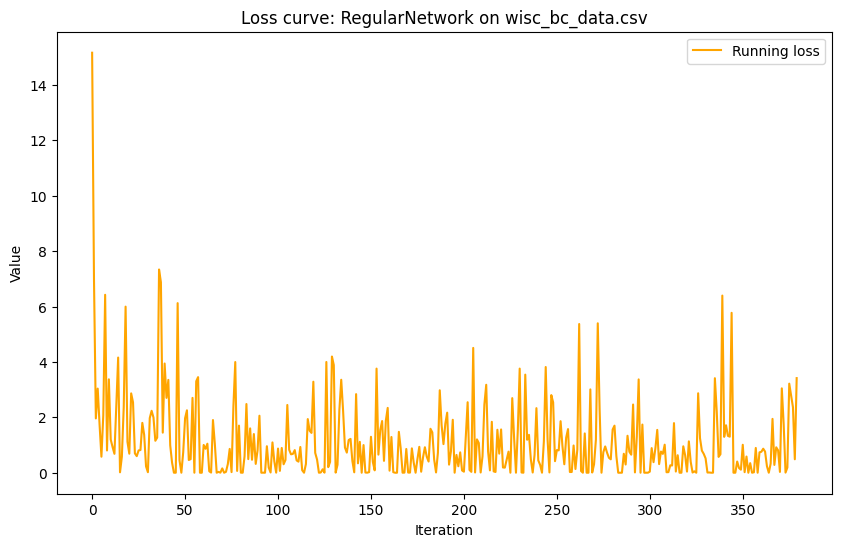

E1/10 S1/38 Loss=0.4740
E1/10 S2/38 Loss=0.0480
E1/10 S3/38 Loss=0.2858
E1/10 S4/38 Loss=0.2373
E1/10 S5/38 Loss=0.2597
E1/10 S6/38 Loss=0.5063
E1/10 S7/38 Loss=0.3357
E1/10 S8/38 Loss=0.2412
E1/10 S9/38 Loss=0.1901
E1/10 S10/38 Loss=0.1632
E1/10 S11/38 Loss=0.0274
E1/10 S12/38 Loss=0.0705
E1/10 S13/38 Loss=0.1673
E1/10 S14/38 Loss=0.1117
E1/10 S15/38 Loss=0.0901
E1/10 S16/38 Loss=0.1299
E1/10 S17/38 Loss=0.0296
E1/10 S18/38 Loss=0.0310
E1/10 S19/38 Loss=0.0568
E1/10 S20/38 Loss=0.1399
E1/10 S21/38 Loss=0.0756
E1/10 S22/38 Loss=0.0512
E1/10 S23/38 Loss=0.0212
E1/10 S24/38 Loss=0.0033
E1/10 S25/38 Loss=0.0011
E1/10 S26/38 Loss=0.0489
E1/10 S27/38 Loss=0.0550
E1/10 S28/38 Loss=0.0071
E1/10 S29/38 Loss=0.0337
E1/10 S30/38 Loss=0.0394
E1/10 S31/38 Loss=0.0131
E1/10 S32/38 Loss=0.0254
E1/10 S33/38 Loss=0.0135
E1/10 S34/38 Loss=0.0407
E1/10 S35/38 Loss=0.0541
E1/10 S36/38 Loss=0.0155
E1/10 S37/38 Loss=0.0003
E1/10 S38/38 Loss=0.0001
E2/10 S1/38 Loss=0.0033
E2/10 S2/38 Loss=0.0227
E2/10 S3/38

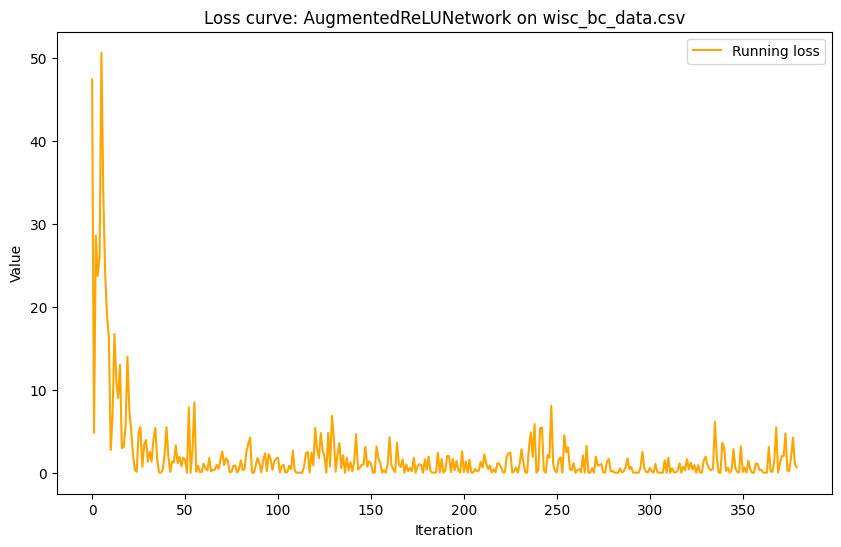

E1/10 S1/116 Loss=0.0152
E1/10 S2/116 Loss=0.0134
E1/10 S3/116 Loss=0.0128
E1/10 S4/116 Loss=0.0107
E1/10 S5/116 Loss=0.0099
E1/10 S6/116 Loss=0.0122
E1/10 S7/116 Loss=0.0109
E1/10 S8/116 Loss=0.0121
E1/10 S9/116 Loss=0.0078
E1/10 S10/116 Loss=0.0074
E1/10 S11/116 Loss=0.0114
E1/10 S12/116 Loss=0.0063
E1/10 S13/116 Loss=0.0092
E1/10 S14/116 Loss=0.0073
E1/10 S15/116 Loss=0.0083
E1/10 S16/116 Loss=0.0067
E1/10 S17/116 Loss=0.0070
E1/10 S18/116 Loss=0.0038
E1/10 S19/116 Loss=0.0129
E1/10 S20/116 Loss=0.0108
E1/10 S21/116 Loss=0.0087
E1/10 S22/116 Loss=0.0056
E1/10 S23/116 Loss=0.0074
E1/10 S24/116 Loss=0.0056
E1/10 S25/116 Loss=0.0061
E1/10 S26/116 Loss=0.0076
E1/10 S27/116 Loss=0.0095
E1/10 S28/116 Loss=0.0085
E1/10 S29/116 Loss=0.0070
E1/10 S30/116 Loss=0.0067
E1/10 S31/116 Loss=0.0078
E1/10 S32/116 Loss=0.0097
E1/10 S33/116 Loss=0.0062
E1/10 S34/116 Loss=0.0058
E1/10 S35/116 Loss=0.0048
E1/10 S36/116 Loss=0.0082
E1/10 S37/116 Loss=0.0102
E1/10 S38/116 Loss=0.0074
E1/10 S39/116 Loss=0.

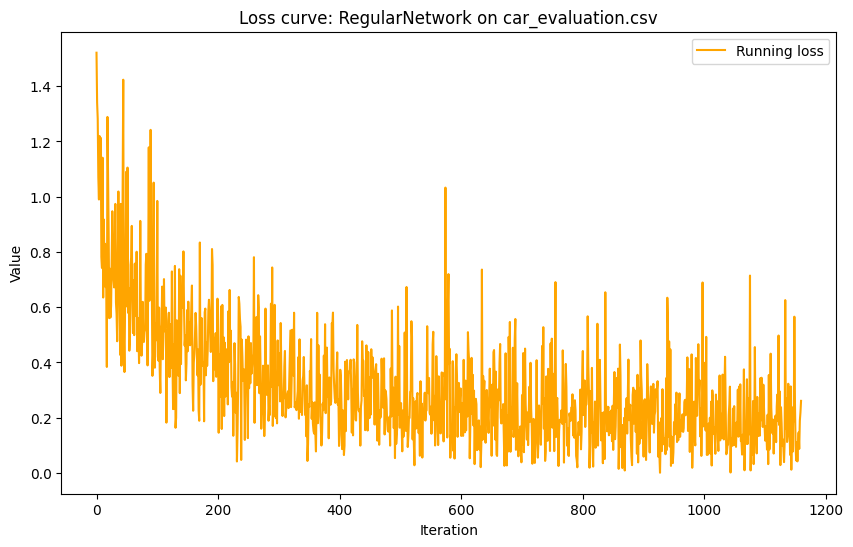

E1/10 S1/116 Loss=0.0145
E1/10 S2/116 Loss=0.0128
E1/10 S3/116 Loss=0.0115
E1/10 S4/116 Loss=0.0120
E1/10 S5/116 Loss=0.0095
E1/10 S6/116 Loss=0.0098
E1/10 S7/116 Loss=0.0110
E1/10 S8/116 Loss=0.0104
E1/10 S9/116 Loss=0.0091
E1/10 S10/116 Loss=0.0057
E1/10 S11/116 Loss=0.0069
E1/10 S12/116 Loss=0.0121
E1/10 S13/116 Loss=0.0059
E1/10 S14/116 Loss=0.0076
E1/10 S15/116 Loss=0.0085
E1/10 S16/116 Loss=0.0087
E1/10 S17/116 Loss=0.0115
E1/10 S18/116 Loss=0.0130
E1/10 S19/116 Loss=0.0092
E1/10 S20/116 Loss=0.0049
E1/10 S21/116 Loss=0.0064
E1/10 S22/116 Loss=0.0088
E1/10 S23/116 Loss=0.0090
E1/10 S24/116 Loss=0.0082
E1/10 S25/116 Loss=0.0069
E1/10 S26/116 Loss=0.0095
E1/10 S27/116 Loss=0.0051
E1/10 S28/116 Loss=0.0055
E1/10 S29/116 Loss=0.0094
E1/10 S30/116 Loss=0.0059
E1/10 S31/116 Loss=0.0052
E1/10 S32/116 Loss=0.0067
E1/10 S33/116 Loss=0.0091
E1/10 S34/116 Loss=0.0041
E1/10 S35/116 Loss=0.0085
E1/10 S36/116 Loss=0.0075
E1/10 S37/116 Loss=0.0040
E1/10 S38/116 Loss=0.0070
E1/10 S39/116 Loss=0.

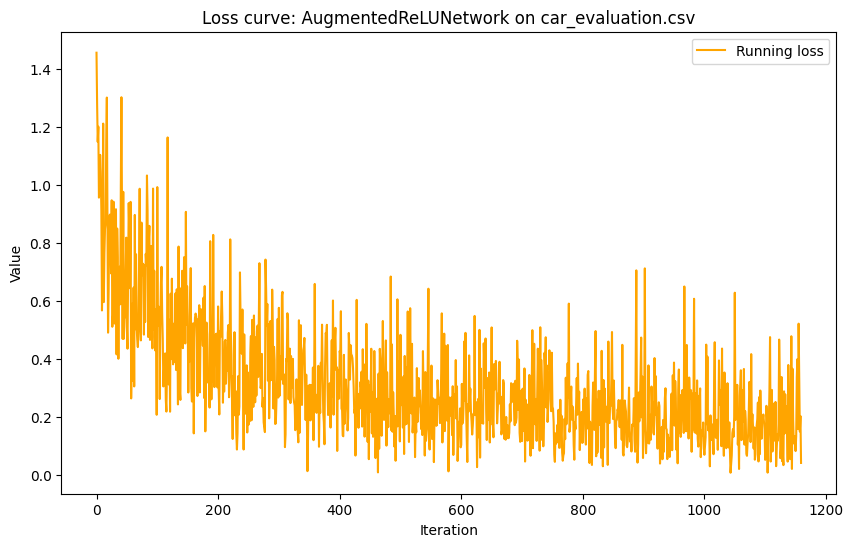

E1/10 S1/436 Loss=40.4457
E1/10 S2/436 Loss=32.9977
E1/10 S3/436 Loss=27.0415
E1/10 S4/436 Loss=21.2955
E1/10 S5/436 Loss=17.4066
E1/10 S6/436 Loss=13.6843
E1/10 S7/436 Loss=10.7110
E1/10 S8/436 Loss=7.4698
E1/10 S9/436 Loss=5.5109
E1/10 S10/436 Loss=3.5159
E1/10 S11/436 Loss=3.0755
E1/10 S12/436 Loss=2.0559


/Users/scales/.pyenv/versions/3.12.3/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([12, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


E1/10 S13/436 Loss=1.7229
E1/10 S14/436 Loss=0.5607
E1/10 S15/436 Loss=0.5311
E1/10 S16/436 Loss=0.7635
E1/10 S17/436 Loss=1.6588
E1/10 S18/436 Loss=1.3965
E1/10 S19/436 Loss=1.2676
E1/10 S20/436 Loss=2.6839
E1/10 S21/436 Loss=3.2458
E1/10 S22/436 Loss=2.2419
E1/10 S23/436 Loss=2.2154
E1/10 S24/436 Loss=1.1567
E1/10 S25/436 Loss=2.3496
E1/10 S26/436 Loss=1.2530
E1/10 S27/436 Loss=1.6164
E1/10 S28/436 Loss=1.4134
E1/10 S29/436 Loss=2.0179
E1/10 S30/436 Loss=0.6391
E1/10 S31/436 Loss=0.6129
E1/10 S32/436 Loss=1.5495
E1/10 S33/436 Loss=0.9019
E1/10 S34/436 Loss=0.5768
E1/10 S35/436 Loss=0.6216
E1/10 S36/436 Loss=0.8019
E1/10 S37/436 Loss=0.5786
E1/10 S38/436 Loss=0.5722
E1/10 S39/436 Loss=0.3723
E1/10 S40/436 Loss=1.1281
E1/10 S41/436 Loss=0.7011
E1/10 S42/436 Loss=1.1340
E1/10 S43/436 Loss=0.5936
E1/10 S44/436 Loss=0.6762
E1/10 S45/436 Loss=0.8279
E1/10 S46/436 Loss=0.9604
E1/10 S47/436 Loss=0.4144
E1/10 S48/436 Loss=0.7380
E1/10 S49/436 Loss=0.5951
E1/10 S50/436 Loss=0.5030
E1/10 S51/43

/Users/scales/.pyenv/versions/3.12.3/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


E2/10 S69/436 Loss=0.2936
E2/10 S70/436 Loss=0.8612
E2/10 S71/436 Loss=0.6164
E2/10 S72/436 Loss=0.3385
E2/10 S73/436 Loss=0.3352
E2/10 S74/436 Loss=0.5447
E2/10 S75/436 Loss=0.4584
E2/10 S76/436 Loss=0.3841
E2/10 S77/436 Loss=0.3038
E2/10 S78/436 Loss=0.2452
E2/10 S79/436 Loss=0.7629
E2/10 S80/436 Loss=0.7914
E2/10 S81/436 Loss=0.5063
E2/10 S82/436 Loss=0.6320
E2/10 S83/436 Loss=0.5185
E2/10 S84/436 Loss=0.8861
E2/10 S85/436 Loss=0.4609
E2/10 S86/436 Loss=0.5791
E2/10 S87/436 Loss=0.6864
E2/10 S88/436 Loss=0.4165
E2/10 S89/436 Loss=1.0788
E2/10 S90/436 Loss=0.5050
E2/10 S91/436 Loss=0.3411
E2/10 S92/436 Loss=0.4358
E2/10 S93/436 Loss=0.9262
E2/10 S94/436 Loss=0.4809
E2/10 S95/436 Loss=0.3599
E2/10 S96/436 Loss=0.4581
E2/10 S97/436 Loss=0.5751
E2/10 S98/436 Loss=1.1048
E2/10 S99/436 Loss=0.4143
E2/10 S100/436 Loss=0.4882
E2/10 S101/436 Loss=0.4563
E2/10 S102/436 Loss=0.2665
E2/10 S103/436 Loss=0.5343
E2/10 S104/436 Loss=0.4387
E2/10 S105/436 Loss=1.0602
E2/10 S106/436 Loss=0.2663
E2/10

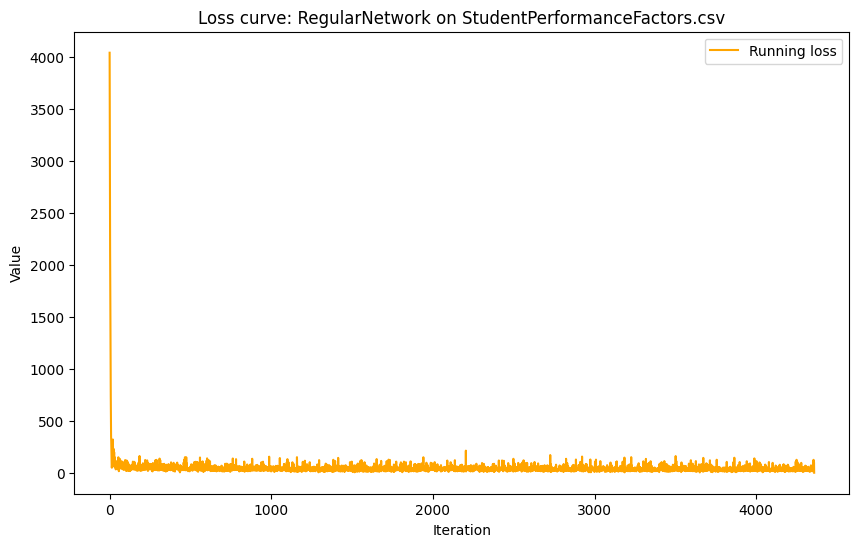

E1/10 S1/436 Loss=41.9512
E1/10 S2/436 Loss=37.4184
E1/10 S3/436 Loss=31.9314
E1/10 S4/436 Loss=25.6247
E1/10 S5/436 Loss=21.2448
E1/10 S6/436 Loss=18.2487
E1/10 S7/436 Loss=14.7755
E1/10 S8/436 Loss=10.0639
E1/10 S9/436 Loss=8.2696
E1/10 S10/436 Loss=6.0567
E1/10 S11/436 Loss=4.8620
E1/10 S12/436 Loss=3.6748
E1/10 S13/436 Loss=2.3302
E1/10 S14/436 Loss=1.7609
E1/10 S15/436 Loss=0.7723
E1/10 S16/436 Loss=0.8078
E1/10 S17/436 Loss=0.2855
E1/10 S18/436 Loss=0.2823
E1/10 S19/436 Loss=1.2824
E1/10 S20/436 Loss=1.0393
E1/10 S21/436 Loss=1.0794
E1/10 S22/436 Loss=0.9717
E1/10 S23/436 Loss=2.7448
E1/10 S24/436 Loss=1.6152
E1/10 S25/436 Loss=2.3090
E1/10 S26/436 Loss=1.8003
E1/10 S27/436 Loss=2.1895
E1/10 S28/436 Loss=2.3034
E1/10 S29/436 Loss=1.7613
E1/10 S30/436 Loss=2.0233
E1/10 S31/436 Loss=1.6160
E1/10 S32/436 Loss=1.0789
E1/10 S33/436 Loss=0.8845
E1/10 S34/436 Loss=1.0682
E1/10 S35/436 Loss=0.5420
E1/10 S36/436 Loss=0.5700
E1/10 S37/436 Loss=0.9284
E1/10 S38/436 Loss=1.1213
E1/10 S39/436

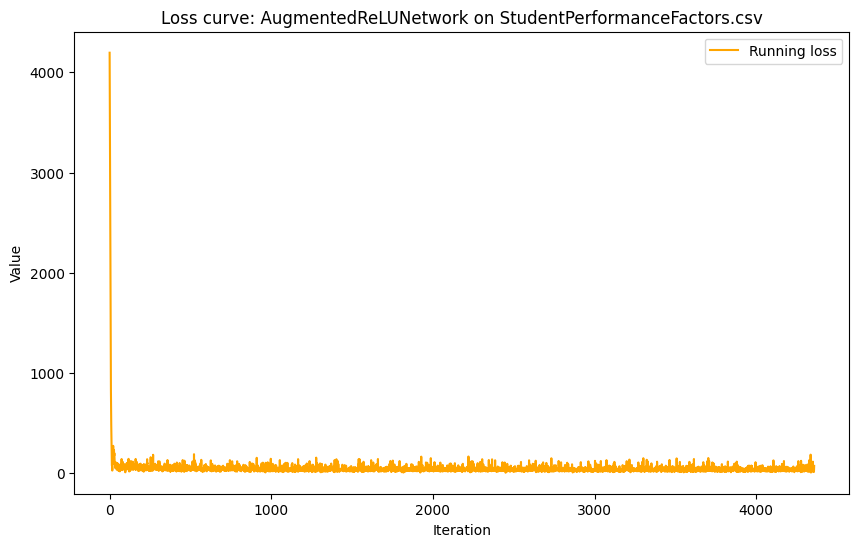

In [102]:

def train_pair_of_networks(
    criterion: nn.CrossEntropyLoss | nn.MSELoss,
    dataset: Dataset,
    learning_rate: float,
    epochs: int,
    model_a_name: str,
    model_b_name: str
):
    modelA = RegularNetwork(
        inputs_count=dataset.features_count,
        outputs_count=dataset.classes_count,
        p = P
    )

    modelA.apply(init_weights)

    train(
        model=modelA,
        dataset=dataset,
        epochs=epochs,
        criterion=criterion,
        optimizer=optim.Adam(
            modelA.parameters(),
            lr=learning_rate
        )
    )

    torch.save(modelA.state_dict(), model_a_name)

    modelB = AugmentedReLUNetwork(
        inputs_count=dataset.features_count,
        outputs_count=dataset.classes_count,
        p = P
    )

    modelB.apply(init_weights)

    train(
        model=modelB,
        dataset=dataset,
        epochs=epochs,
        criterion=criterion,
        optimizer=optim.Adam(
            modelB.parameters(),
            lr=learning_rate
        )
    )


    torch.save(modelB.state_dict(), model_b_name)

train_pair_of_networks(
    classification_task.criterion,
    make_dataset1(batch_size=BATCH_SIZE),
    learning_rate=LEARNING_RATE,
    epochs=EPOCHS,
    model_a_name='model-1A-c.pth',
    model_b_name='model-1B-c.pth'
)

train_pair_of_networks(
    classification_task.criterion,
    make_dataset2(batch_size=BATCH_SIZE),
    learning_rate=LEARNING_RATE,
    epochs=EPOCHS,
    model_a_name='model-2A-c.pth',
    model_b_name='model-2B-c.pth'
)

train_pair_of_networks(
    regression_task.criterion,
    make_dataset3(batch_size=BATCH_SIZE),
    learning_rate=LEARNING_RATE,
    epochs=EPOCHS,
    model_a_name='model-3A-r.pth',
    model_b_name='model-3B-r.pth'
)


In [103]:
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, f1_score, r2_score, mean_squared_error

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def positive_probs_from(probs: torch.Tensor) -> list:
    return np.array(probs)[:, 0]

def evaluate_classification_model(
    dataset: Dataset,
    path: str,
    constructor: type,
    noise_factor: float,
    is_binary_classification: bool,
    inputs_count: int,
    outputs_count: int
):
    evaluated_model = constructor(
        inputs_count=inputs_count,
        outputs_count=outputs_count,
        p=P
    )

    evaluated_model.load_state_dict(torch.load(path))

    evaluated_model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in dataset.data.test_loader:
            outputs = evaluated_model(
                inputs + torch.randn(inputs.shape) * noise_factor
            )
            probs = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    accuracy = correct / total
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    if is_binary_classification:
        all_probs = np.array(all_probs)[:, 0]

    roc_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')

    return accuracy, f1, roc_auc

def evaluate_regression_model(
    dataset: Dataset,
    model_path: str,
    constructor: type,
    noise_factor: float,
    inputs_count: int,
    outputs_count: int
):
    evaluated_model = constructor(
        inputs_count=inputs_count,
        outputs_count=outputs_count,
        p=P
    )

    evaluated_model.load_state_dict(torch.load(model_path))

    evaluated_model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in dataset.data.test_loader:
            noisy_inputs = inputs + torch.randn(inputs.shape) * noise_factor
            outputs = evaluated_model(noisy_inputs)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(outputs.cpu().numpy())

    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)

    r2 = r2_score(all_labels, all_predictions)
    mse = mean_squared_error(all_labels, all_predictions)

    return r2, mse

def evaluate_model(
    dataset: Dataset,
    model_path: str,
    constructor: type,
    is_binary_classification: bool,
    is_regression: bool,
    inputs_count: int,
    outputs_count: int
):
    if is_regression:
        samples = {
            'noise_factor': NOISE_FACTORS,
            'r2': [],
            'mse': [],
        }

        for noise_factor in NOISE_FACTORS:
            r2, mse = evaluate_regression_model(
                dataset=dataset,
                model_path=model_path,
                constructor=constructor,
                noise_factor=noise_factor,
                inputs_count=inputs_count,
                outputs_count=outputs_count,
            )

            samples['r2'].append(r2)
            samples['mse'].append(mse)

        return pd.DataFrame(samples)
    else:
        samples = {
            'noise_factor': NOISE_FACTORS,
            'accuracy': [],
            'f1': [],
            'roc_auc': [],
        }

        for noise_factor in NOISE_FACTORS:
            accuracy, f1, roc_auc = evaluate_classification_model(
                dataset=dataset,
                path=model_path,
                constructor=constructor,
                noise_factor=noise_factor,
                is_binary_classification=is_binary_classification,
                inputs_count=inputs_count,
                outputs_count=outputs_count,
            )

            samples['accuracy'].append(accuracy)
            samples['f1'].append(f1)
            samples['roc_auc'].append(roc_auc)

        return pd.DataFrame(samples)

def plot_evaluation_of_classification(df: pd.DataFrame, title: str):
    plt.figure(figsize=(10, 6))

    plt.plot(df['noise_factor'], df['accuracy'], label='Accuracy', marker='o')
    plt.plot(df['noise_factor'], df['f1'], label='F1 Score', marker='o')
    plt.plot(df['noise_factor'], df['roc_auc'], label='ROC AUC', marker='o')

    plt.xscale('log')

    plt.xlabel('Noise Factor')
    plt.ylabel('Metric Value')
    plt.title(f'Metrics vs Noise Factor: {title}')
    plt.legend()

    plt.grid(True, which="both", ls="--")
    plt.show()

# XXX split into two..
def plot_evaluation_of_regression(df: pd.DataFrame, title: str):
    plt.figure(figsize=(10, 6))

    plt.plot(df['noise_factor'], df['mse'], label='Mean Square Error', marker='o')

    # plt.xscale('log')

    plt.xlabel('Noise Factor')
    plt.ylabel('Metric Value')
    plt.title(f'Metrics vs Noise Factor: {title}')
    plt.legend()

    plt.grid(True, which="both", ls="--")

    plt.show()

    plt.figure(figsize=(10, 6))

    plt.plot(df['noise_factor'], df['r2'], label='R^2', marker='o')

    # plt.xscale('log')

    plt.xlabel('Noise Factor')
    plt.ylabel('Metric Value')
    plt.title(f'Metrics vs Noise Factor {title}')
    plt.legend()

    plt.grid(True, which="both", ls="--")
    plt.show()

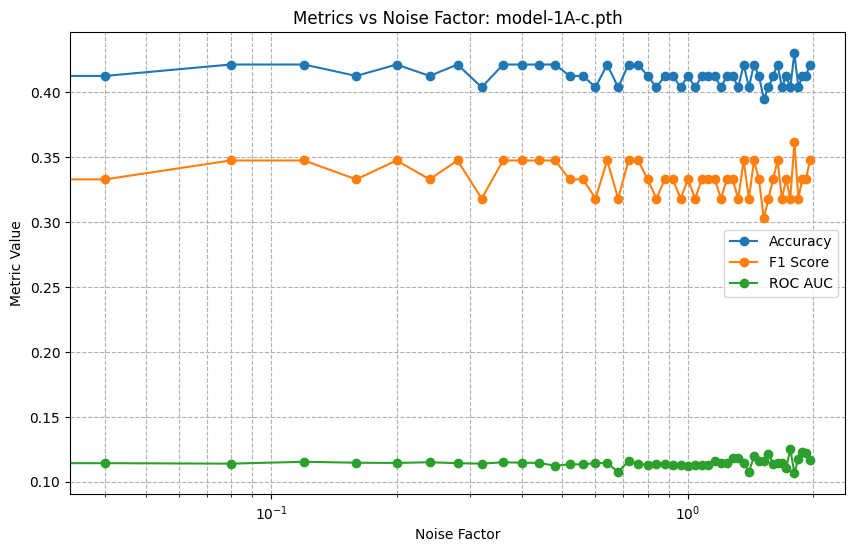

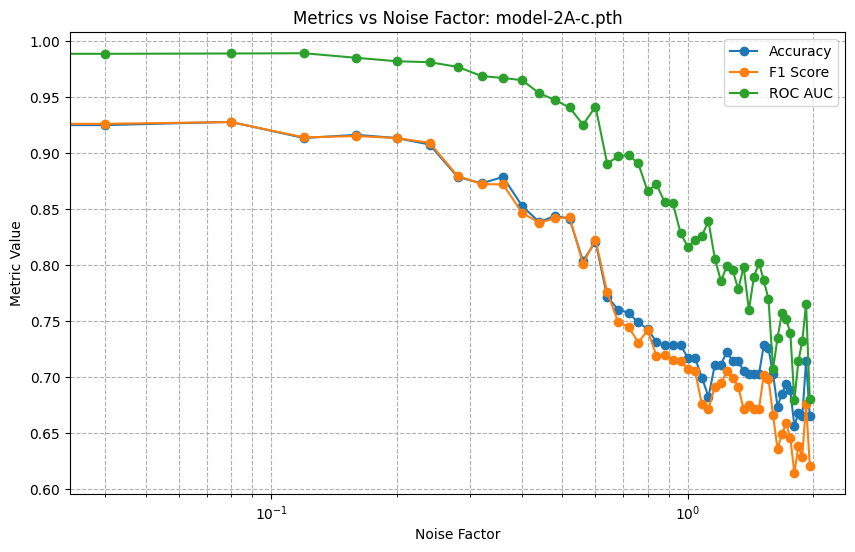

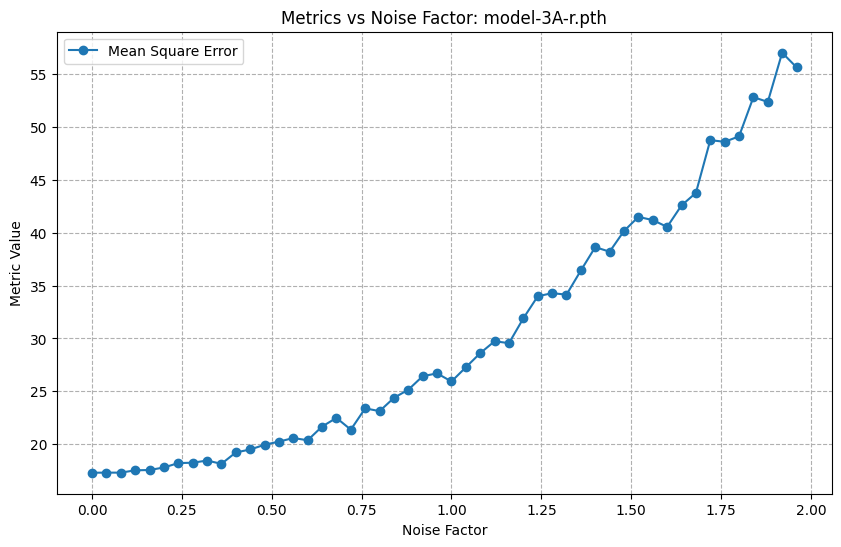

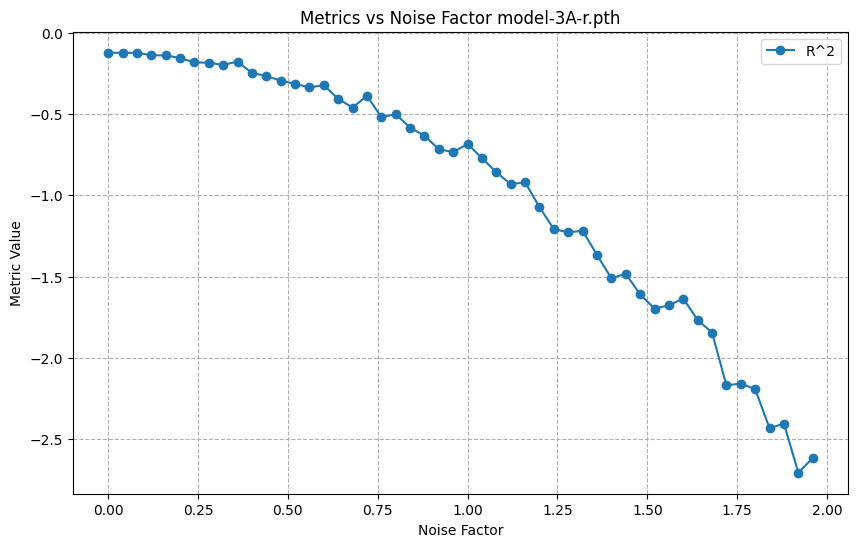

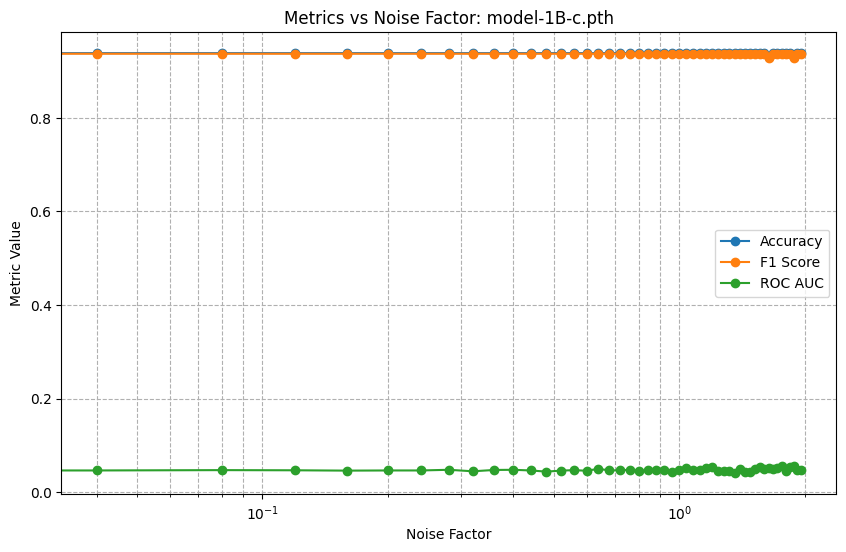

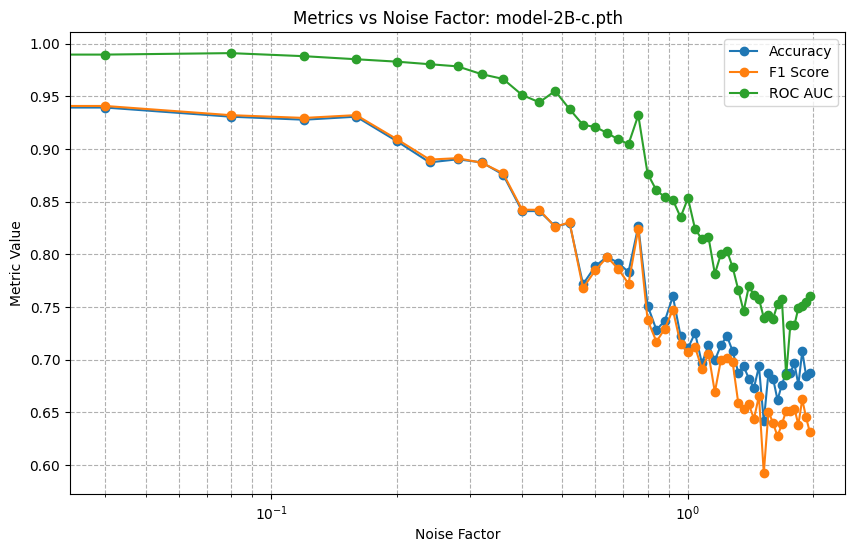

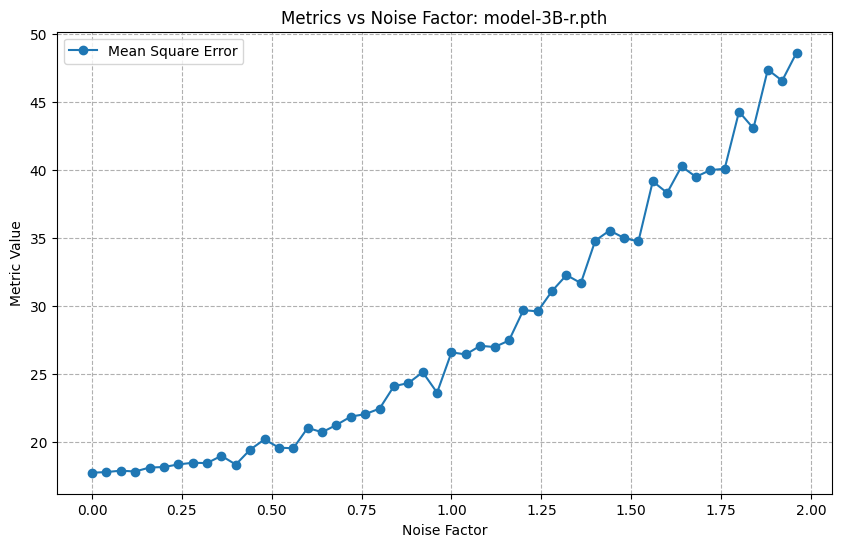

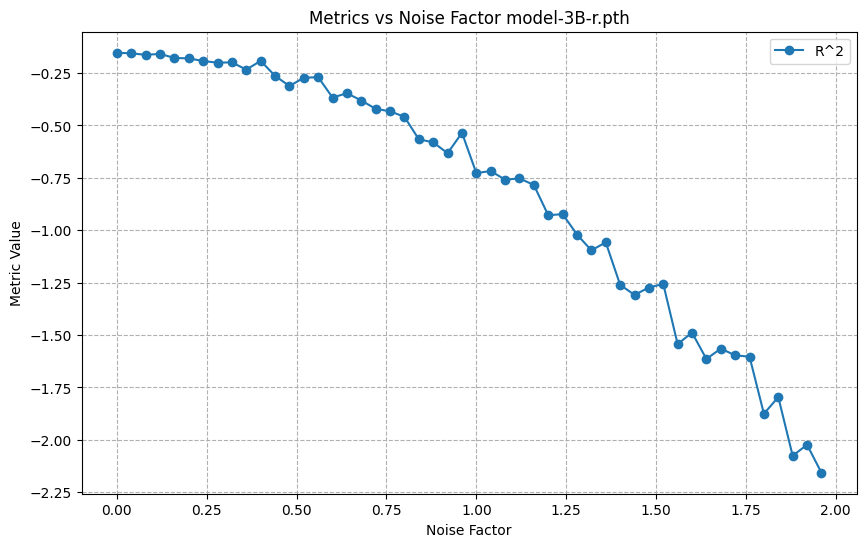

In [104]:
def evaluate(model_a_or_b: str, constructor: type):
    model_path=f"model-1{model_a_or_b}-c.pth"
    plot_evaluation_of_classification(evaluate_model(
        dataset=make_dataset1(batch_size=BATCH_SIZE),
        model_path=model_path,
        constructor=constructor,
        is_binary_classification=True,
        is_regression=False,
        inputs_count=30,
        outputs_count=2
    ), title=model_path)

    model_path=f"model-2{model_a_or_b}-c.pth"
    plot_evaluation_of_classification(evaluate_model(
        dataset=make_dataset2(batch_size=BATCH_SIZE),
        model_path=model_path,
        constructor=constructor,
        is_binary_classification=False,
        is_regression=False,
        inputs_count=6,
        outputs_count=4
    ), title=model_path)

    model_path=f"model-3{model_a_or_b}-r.pth"
    plot_evaluation_of_regression(evaluate_model(
        dataset=make_dataset3(batch_size=BATCH_SIZE),
        model_path=model_path,
        constructor=constructor,
        is_binary_classification=False,
        is_regression=True,
        inputs_count=19,
        outputs_count=1
    ), title=model_path)

evaluate('A', RegularNetwork)
evaluate('B', AugmentedReLUNetwork)